# Watson NLU in IBM Cloud Pak For Data 3.0 for Conversation Analysis of a Watson Assistant Chatbot

The purpose of this notebook is to demo how to extract logs using the Watson Assistant API, authenticate and call the NLU API for conversation log analysis, and enhance other analytical tools for visual monitoring of the chatbot post production. 

## Table of Contents

* [Extract Conversation Logs from Watson Assistant](#wa)
* [Authenticate Watson NLU API](#nlu)
* [Analyze Conversation Logs](#acl)
* [Monitor Chatbot Performance](#mcp)


## Extract Conversation Logs From Watson Assistant <a class="anchor" id="wa"></a>

In this section, you will be using the Watson Assistant API to extract conversation logs in a JSON file.  First, you will be authenticating the API, in which you will need to enter the required credentials.  Then, you will be calling on a request to list the log events in the workspace specified.

#### Credentials Required:
* API Key of your Watson Assistant Chatbot
* URL of your Watson Assistant Chatbot
* Workspace ID, also identified as Skill ID


In [2]:
!pip install --upgrade "ibm-watson>=4.5.0"

In [3]:
#Import packages needed to extract Watson Assistant conversation logs
#Use AssistantV2 if your Watson Assistant chatbot is on a Cloud Pak for Data Environment with WA V2 API
from ibm_watson import AssistantV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

authenticator = IAMAuthenticator('YOUR_API_KEY') 
assistant = AssistantV1(
    version='2020-04-01',
    authenticator = authenticator
)

assistant.set_service_url('YOUR_URL') 

In [4]:
# Import notebook dependencies
import sys, os

# Allows import of libraries/functions (data assets) within the project
sys.path.append(os.path.join(os.getcwd(),'..','..'))
sys.path.insert(1, '/project_data/data_asset/')

# Allows you to acccess the CP4D Project environment
from project_lib import Project
project = Project.access()


In [5]:
# upload custom functions from Watson_Function.py
from Watson_Function import *

# upload json_normalize function to help normalize structred json into flat table
from pandas.io.json import json_normalize

# Provide the workspace id you want to analyze
workspace_id='YOUR_WORKSPACE_ID'

# defines workspace credentials
if len(workspace_id) > 0:
    # Fetch the worksapce info. for the input workspace id
    workspace = assistant.get_workspace(workspace_id = workspace_id, export=True).get_result()
    # Store the workspace details in a dataframe
    df_workspace = json_normalize(workspace)
else:
    workspace_loaded = False

if len(workspace_id) > 0:
    # Filter to be applied while fetching logs, e.g., removing empty input 'meta.summary.input_text_length_i>0', 'response_timestamp>=2018-09-18'
    filter = None

    # Send this info into the get_logs function
    workspace_creds={'sdk_object':assistant, 'ws_id':workspace['workspace_id'], 'ws_name':workspace['name']}

    # Fetch the logs for the workspace
    df = get_logs_jupyter(num_logs=100000, log_list=[], workspace_creds=workspace_creds, log_filter = filter)

Reading from file: Coffee Shop Website CommunicationNone_100000.json
Workspace logs loaded successfully with 15 records


In [6]:
# Process to unpack embedded json text

# import pandas to help with dataframe manipulations
import pandas as pd

#Unpack dictionaries
context_df = unpack_context(df['response'],'context')
temp_intents_df = unpack_intents(df['response'],'intents')
input_df = unpack_dictionary(df['response'],'input')
output_df = unpack_dictionary(df['response'],'output')

#Initial cleaning
input_df.rename(columns={'text':'input_text'}, inplace=True)
output_df.rename(columns={'text':'output_text'}, inplace=True)
output_df[['output1']] = pd.DataFrame(output_df['output_text'].values.tolist())
output_df.drop(columns=['output_text'], inplace=True)

#Combine dataframes
working_df = pd.concat([df,context_df,temp_intents_df, input_df,output_df],axis=1)

#Save to Cloud Pack For Data
project.save_data(data=working_df.to_csv(index=False),file_name="Clean_Log.csv",overwrite=True)

#Save to JupyterLab Environment
working_df.to_csv('Clean_Log.csv',index=False)

## Authenticate Watson NLU API <a class="anchor" id="nlu"></a>

Now that you have extracted the logs of your Watson Assistant chatbot, you will authenticate the Watson NLU service instance API in the following section.

#### Credentials Required:

* Your username for the IBM Cloud Pak for Data 3.0 environment (This should have been provided to you by your system administrator)
* Your password for the IBM Cloud Pak for Data 3.0 environment
* The URL of the IBM Cloud Pak for Data 3.0 environment, in which the Watson NLU service instance is provisioned
* The NLU service instance URL
    * This can be found in the connection details section of the service instance details page or in the credentials file you downloaded when you provisioned the instance. 

In [7]:
#Import required packages to call the NLU API
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import CloudPakForDataAuthenticator


authenticator = CloudPakForDataAuthenticator(
    'YOUR_USERNAME',  
    'YOUR_PASSWORD',
    'URL',
    disable_ssl_verification=True   #False for customer environments
)

natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2020-06-15',
    authenticator=authenticator
)

natural_language_understanding.set_service_url('NLU_SERVICE_INSTANCE_URL') 

natural_language_understanding.set_disable_ssl_verification(True) #False for customer environments

## Analyze NLU Output of Conversation Logs <a class="anchor" id="acl"></a>

Once you have successfully authenticated the Watson NLU API, you can call on the following request to analyze the text from the conversation logs

In [8]:
# aggregate working dataframe into conversation_id
nlu_text_df = working_df.groupby(['conversation_id']).agg({'input_text':lambda x: list(x)})

# remove any columns with no input text
nlu_text_df = nlu_text_df[nlu_text_df['input_text'].apply(lambda txt: len(txt))>1]

# show top rows left with input text
nlu_text_df.head()

,input_text
conversation_id,
b5b4c17b-fb5a-4f13-bd81-d810910307da,"[That's great to know!, I will ask about coffe..."
dcef48e9-bc7d-4e76-ab34-ae7cbabaa149,"[Ugh, I want to order coffee, You are not bein..."


In [9]:
#Import requires pacakges to analyze conversation logs
from ibm_watson.natural_language_understanding_v1 import Features, CategoriesOptions, EmotionOptions, EntitiesOptions 
from ibm_watson.natural_language_understanding_v1 import KeywordsOptions, SentimentOptions, RelationsOptions

# create empty dictionary for storage of NLU feedback
nlu_dct={}
# retrieves nlu for each conversation_id
for text, conversation_id in zip(nlu_text_df.input_text, nlu_text_df.index):

    response = natural_language_understanding.analyze(
            text=' '.join(text), # aggregates list into a string
            features = Features(sentiment = SentimentOptions(document=True),
                                keywords=KeywordsOptions(), 
                                categories=CategoriesOptions(),
                                entities=EntitiesOptions()
                               )).get_result()
    del response['warnings']

    nlu_dct.__setitem__(conversation_id, response)

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


### Interpretation of Output from Natural Language Understanding
The code below prints out some useful output from the Natural Language Understanding API. The API quickly retrieves useful text analytics that you can use as features for a model or as aggregations on customer satisfaction with their chatbot experience. 

The features we have included here include:
- Sentiment Score and Label -- The sentiment score is a composite score of the sentiment within the text. NLU uses a pretrained model to understand the context around your text and give you a more coherent sentiment score. This score can range from -1 to 1 with -1 being the most negative and 1 being the most postive. The label is purely a function of whether or not the text is more positive or negative and corresponds to the sentiment score.

- Entity Text and Entity Type -- Entites are words that correspond to real-world things. This includes people, places and organizations. NLU has been trained to recognize entities in text and also uses the context within the text to derive entities from the overall text. In our chatbot, NLU beleives that 'coffee' is a Person. While we know that coffee is not referring to a person, the context around the word makes NLU think that maybe it is an entity to be included. 

- Entity Relevance and Confidence -- These are two measurements that say how relevant the entity is to the text overall and how confident NLU is that the entity extracted is correctly identified. Relevance and Confidence both range from 0 to 1. The closer the relevance is to 1, the relevant it is to the text overall and vice versa. The clsoer confidence is to 1, the more confident NLU is that it has categorized the entity correctly. In our example, coffee is highly relevant with a score of ~0.98 but NLU is not very confident that it has identified the entity correctly with a score of ~0.3

- Keywords and Keyword Relevance -- Keywords are the terms that best describe the document. They are typically the subject at hand and the focus of the text. Since our chatbot is a for a coffee shop, it make sense that the keywords for both conversations are focused on coffee and making coffee orders. NLU also extracts a relevance score for keywords, ranging from 0 to 1 with more relevant keywords being closer to 1. 

- Categories and Category Score -- Categories returns a five-level taxonomy of the content. The top three categories are returned. Watson NLU has already been trained on a large corpus of text so it has a large dictionary of categories that it can recognize. The category score, which ranges from 0 to 1,  gives a continuous measure of how likely the text is to be about that category, with a score closer to 1 meaning the text is like the defined. category. 

In [10]:
for key, value in nlu_dct.items():
    print('Conversation Text:', ' ' .join(nlu_text_df.loc[key]['input_text']))
    print('Conversation ID: ', key)
    print('Sentiment Score: ' ,value['sentiment']['document']['score'], 
          'Sentiment Label: ',value['sentiment']['document']['label'])
    print('Entities:', [entity['text'] for entity in value['entities']], 
          'Type:', [entity['type'] for entity in value['entities']], 
          'Relevance:', [entity['relevance'] for entity in value['entities']],
          'Confidence:', [entity['confidence'] for entity in value['entities']])
    print('Keywords: ', [word['text'] for word in value['keywords']], 'Relevance: ', [word['relevance'] for word in value['keywords']])
    print('Categories:', [category['label'] for category in value['categories']], 'Category Score:', [category['score'] for category in value['categories']])
    print('\n')

Conversation Text: That's great to know! I will ask about coffee'  Thank you! I'm very pleased :)
Conversation ID:  b5b4c17b-fb5a-4f13-bd81-d810910307da
Sentiment Score:  0.926355 Sentiment Label:  positive
Entities: ['coffee'] Type: ['Person'] Relevance: [0.978348] Confidence: [0.303351]
Keywords:  ['coffee'] Relevance:  [0.723014]
Categories: ['/food and drink', '/food and drink/beverages', '/food and drink/food'] Category Score: [0.737155, 0.702425, 0.63218]


Conversation Text: Ugh I want to order coffee You are not being helpful at all  Hi coffee make an order I want to place an order for coffee I will have to
Conversation ID:  dcef48e9-bc7d-4e76-ab34-ae7cbabaa149
Sentiment Score:  0.47438 Sentiment Label:  positive
Entities: [] Type: [] Relevance: [] Confidence: []
Keywords:  ['Hi coffee', 'order', 'coffee'] Relevance:  [0.90571, 0.785963, 0.778323]
Categories: ['/food and drink/beverages', '/food and drink/food', '/food and drink/food/breakfast foods'] Category Score: [0.797485,

## Monitor Chatbot Performance <a class="anchor" id="mcp"></a>

In this section, you will learn how to monitor chatbot performance using analytical visuals, such as a heat map.

### Create a Working Data Frame
This will allow you to more easily analyze your chatbot performance by taking it from its json format and converting it into a pandas dataframe.

In [11]:
project = Project.access()
log_file = project.get_file('Clean_Log.csv') # call the Clean Log back into the file to work with 
df_data = pd.read_csv(log_file)
df_data.head()

,language,log_id,request,request_timestamp,response,response_timestamp,workspace_id,conversation_id,integrations,branch_exited,...,message_type,options,source,input_text,generic,internal,log_messages,nodes_visited,nodes_visited_details,output1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1cee51ed-219f-4193-8eb3-5e5cf709dcdb,{'chat': {'browser_info': {'client_ip_address'...,True,...,text,"{'return_context': True, 'export': True, 'debu...","{'type': 'user', 'id': 'anonymous_IBMuid-3d353...",NaN,"[{'response_type': 'text', 'text': 'Hello. Wel...",NaN,[],['Welcome'],"[{'dialog_node': 'Welcome', 'title': 'Welcome'...",Hello. Welcome to our coffee shop website! How...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4adec35b-37a5-4193-be42-9792a5f6a954,{'chat': {'browser_info': {'client_ip_address'...,True,...,text,"{'return_context': True, 'export': True, 'debu...","{'type': 'user', 'id': 'anonymous_IBMuid-0bc82...",NaN,"[{'response_type': 'text', 'text': 'Hello. Wel...",NaN,[],['Welcome'],"[{'dialog_node': 'Welcome', 'title': 'Welcome'...",Hello. Welcome to our coffee shop website! How...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dcef48e9-bc7d-4e76-ab34-ae7cbabaa149,{'chat': {'browser_info': {'client_ip_address'...,True,...,text,"{'return_context': True, 'export': True, 'debu...","{'type': 'user', 'id': 'anonymous_IBMuid-0bc82...",Ugh,"[{'response_type': 'text', 'text': ""I didn't u...",{'fallback': True},[],['Anything else'],"[{'dialog_node': 'Anything else', 'title': 'An...",I didn't understand. You can try rephrasing.
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dcef48e9-bc7d-4e76-ab34-ae7cbabaa149,{'chat': {'browser_info': {'client_ip_address'...,True,...,text,"{'return_context': True, 'export': True, 'debu...","{'type': 'user', 'id': 'anonymous_IBMuid-0bc82...",I want to order coffee,"[{'response_type': 'text', 'text': ""I didn't u...",{'fallback': True},[],['Anything else'],"[{'dialog_node': 'Anything else', 'title': 'An...",I didn't understand. You can try rephrasing.
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dcef48e9-bc7d-4e76-ab34-ae7cbabaa149,{'chat': {'browser_info': {'client_ip_address'...,True,...,text,"{'return_context': True, 'export': True, 'debu...","{'type': 'user', 'id': 'anonymous_IBMuid-0bc82...",You are not being helpful at all,"[{'response_type': 'text', 'text': ""I'm sorry ...",NaN,[],['node_3_1594734785013'],"[{'dialog_node': 'node_3_1594734785013', 'titl...",I'm sorry I am not being very helpful. Please ...


In [12]:
# Creates new intent_df that contains cleaned data

df_conf = pd.DataFrame(df_data.groupby(['intent_type']).mean()['intent_confidence'].sort_values())
df_count= pd.DataFrame(df_data.groupby(['intent_type']).count()['user_id'])

intent_df1 = pd.merge(df_conf, df_count, left_index=True, right_index=True)
intent_df1=intent_df1.rename(columns={'user_id':'count'})


In [13]:
%%capture
!pip install squarify

# import visualization packages
import matplotlib
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

#Add Heatmap
cm = sns.light_palette('blue', as_cmap=True)
intent_df1.style.background_gradient(cmap=cm)

# create a color palette, mapped to these values
cmap = matplotlib.cm.RdYlGn
mini=min(intent_df1['intent_confidence'])
maxi=max(intent_df1['intent_confidence'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in intent_df1['intent_confidence']]
 

Box Size: Number of Questions Asked
Box Color: Intent Confidence Level


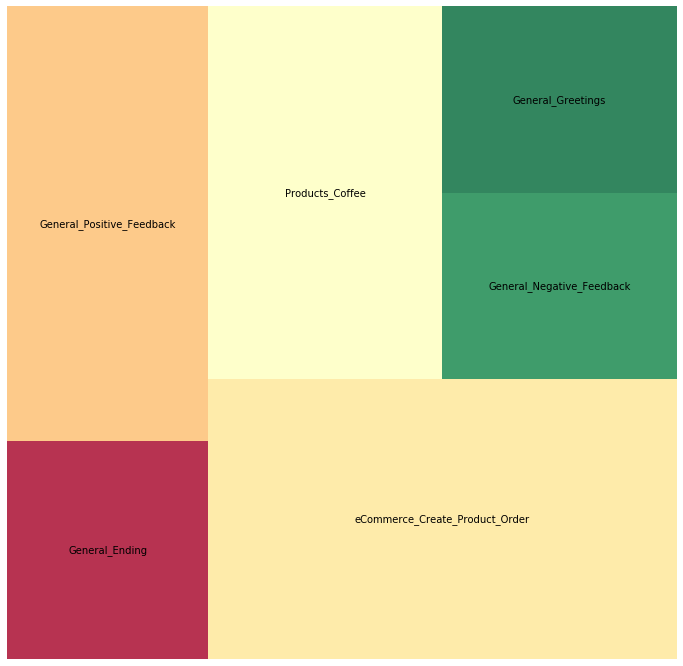

In [14]:
# Heatmap
plt.figure(figsize=(12,12))
squarify.plot(sizes=intent_df1['count'], label=intent_df1.index, alpha=.8, color=colors )
plt.axis('off')
print('Box Size: Number of Questions Asked')
print('Box Color: Intent Confidence Level')

plt.show()